# Markov random field modelling

Write a function that, given an input image $D$ and a segmentation, for example $S_{GT} = \{1, 2,3\}$ , produces a histogram of the pixel intensities and histograms of the pixel
intensities divided into segmentation classes.


In [1]:
import numpy as np
import math
#import maxflow
import skimage
import scipy.ndimage as snd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import scipy



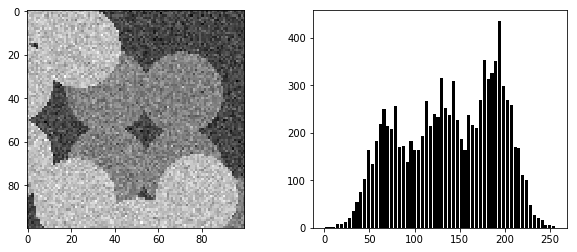

In [2]:
D = skimage.io.imread("noisy_circles.png").astype(np.int);
S = [1, 2, 3]

def Hist(D, S):
    D = 1

f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(D, cmap='gray');
ax[1].hist(D.ravel(), bins=60, range=[0,256], rwidth=0.8, color='k');

What does this histogram say about the chances of obtaining
a reasonable segmentation of D using a method which considers only
pixel intensities, for example thresholding?

The one clique potentials for the likelihood energy as the squared distance from the
class mean  

$$ 
V_{1}\left(f_{i}\right)=\alpha\left(\mu\left(f_{i}\right)-d_{i}\right)^{2}
 $$
 

## Using PyMaxflow for minimum graph cuts

Let's start with a simple graph, following the tutorial on http://pmneila.github.io/PyMaxflow/tutorial.html

<img src="http://pmneila.github.io/PyMaxflow/_images/graph.png" style="height:250px">   

It has a source node $s$, a sink node $t$ and the two nodes $0$.

In [ ]:
# Create the graph with integer capacities.
g = maxflow.Graph[int](2, 2)
# Add two (non-terminal) nodes. Get the index to the first one.
nodes = g.add_nodes(2)
# Create two edges (forwards and backwards) with the given capacities.
# The indices of the nodes are always consecutive.
g.add_edge(nodes[0], nodes[1], 1, 2)
# Set the capacities of the terminal edges
# for the first node:
g.add_tedge(nodes[0], 2, 5)
# for the second node:
g.add_tedge(nodes[1], 9, 4)

In [ ]:
flow = g.maxflow()
print("Maximum flow:", flow)

In [ ]:
print("Segment of the node 0:", g.get_segment(nodes[0]))
print("Segment of the node 1:", g.get_segment(nodes[1]))

<img src="http://pmneila.github.io/PyMaxflow/_images/graph2.png" style="height:250px"> 

### Binary image segmentation 

Next, we'll explore how to use the maxflow library to segment a CT scan of a mouse tibia.

In [ ]:
boneCT_location = 'data/V12_10X_x502.png'
im = skimage.io.imread(boneCT_location).astype(np.float64)

## 5.2 Exercise : Modelling

In this exercise we define an objective function for segmenting a noisy image, similar to the problem in Li Section 3.2.2. \\

We want to be minimizing the posterior energy of the configuration $f$. Our objective function is therefore:

\begin{align}
min\{ E(f) \} = min\{ U(f|d) \}= min\{ U(d|f)+U(f) \} 
\end{align}
with the likelihood energy 
\begin{align}
U(d|f) = \sum_{i \in D}  \alpha \cdot ( \mu ( f_i ) − d_i )^2
\end{align}
and the prior energy
\begin{align}
U(f) = \sum_{i,j \in D, i \neq j}
\begin{cases}
0 \hspace{5mm} f_i = f_j \\
1 \hspace{5mm} \text{otherwise}
\end{cases}
\end{align}




In [45]:
# Define a function to produce histograms:
def Histogrammify(im, imlabeled, whatLabel):
    # Identify indices of the labeled image with specified label. These indices correspond to the original image.
    ilabel = np.asarray(np.where(imlabeled == whatLabel)).T
    temp = list()
    for j in ilabel:
        # Save image pixel values from specified label as a list:
        temp.append(im[tuple(j)])
    temp.sort()
    
    # Sort this list so that no values are repeated. Make a counter to keep track of the amount of repititions:
    PixVals = [temp[0]]
    Counts = [1]
    for j in range(1,len(temp)):
        if temp[j] != temp[j-1]:
            PixVals.append(temp[j]) 
            Counts.append(1)
        else: 
            Counts[-1] +=1
    Counts = np.array(Counts)
    return PixVals, Counts

# Define a function to calculate the image energy (only developed for three labels):
def Energy(im, imlabeled):
    # Define parameters:
    mu = [70, 130, 190]
    alpha = 0.0005
    h,w = im.shape
    LiklhdEnergy = 0
    PriorEnergy = 0

    for r in range(1,h-1):
        for c in range(1,w-1):
            # Start with the Likelihood Energy:
            LiklhdEnergy += alpha*(mu[imlabeled[r,c]-1] - im[r,c])**2  
            
            # alpha*(mu[1] - D)*(mu[1] - D) also works, but passing imlabel as indices to mu is hard:
            # list2label = np.asarray(np.where(Dlabel == 1)).T.tolist() 
            # print(list2label)
            # for i in list2label:
                # print(D[tuple(i)]) so you would also need two for-loops...
            
            # Now look at the prior energy: take the four neighbours and compare labels
            CompList = np.asarray([imlabeled[r-1,c], imlabeled[r+1,c], imlabeled[r,c-1], imlabeled[r,c+1]])
            trues = (CompList != imlabeled[r,c])
            PriorEnergy += sum(trues)
            
    return round(LiklhdEnergy,2), PriorEnergy


### 5.2.1 The ground truth

A linear mapping can be used to obtain a desired minimum pixel value $v_{min,d}$ and maximum $v_{max,d}$ 

\begin{align}
g(x,y) = \frac{v_{max,d} - v_{min,d}}{v_{max} - v_{min}} \cdot (f(x,y) - v_{min}) + v_{min,d}
\end{align}

The three different values in GT are (70, 130, 190)
The three different labels in GT are (1, 2, 3) 

For the ground truth, the likelihood energy is 0.0 and the prior energy is 1268
The total energy is 1268.0


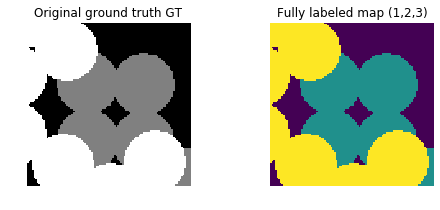

In [46]:
GT = skimage.io.imread("noise_free_circles.png").astype(np.int);

# What are the maximum and minimum values in D?
print('The three different values in GT are', (GT[10,90], GT[30,70], GT[1,1]))

# We want to rescale (70, 130, 190) to (1,2,3):
GTlabel = (3-1)/(190-70)*(GT-70) + 1
GTlabel = GTlabel.astype(np.int)
print('The three different labels in GT are', (GTlabel[10,90], GTlabel[30,70], GTlabel[1,1]),'\n')

f, ax = plt.subplots(1,2, figsize=(8,3))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0].imshow(GT, cmap='gray')
ax[0].set(title=('Original ground truth GT'))
ax[1].imshow(GTlabel);
ax[1].set(title=('Fully labeled map (1,2,3)'))

energy = Energy(GT, GTlabel)
print('For the ground truth, the likelihood energy is', energy[0], 'and the prior energy is',energy[1])
print('The total energy is', energy[0] + energy[1])


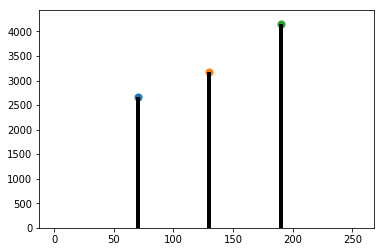

In [52]:
# Histogram of the ground truth
plt.hist(GT.ravel(), bins=60, range=[0,256], rwidth=0.8, color='k');
for i in (1,2,3):
    PixVals, Counts = Histogrammify(GT, GTlabel, i)
    plt.scatter(PixVals, Counts, s = 50  )

### 5.2.2 Segmentation based on simple thresholding

For the segmentation based on thresholding, the likelihood energy is 1453.47 and the prior energy is 7052
The total energy is 8505.47
This is a lot higher than the ground truth.


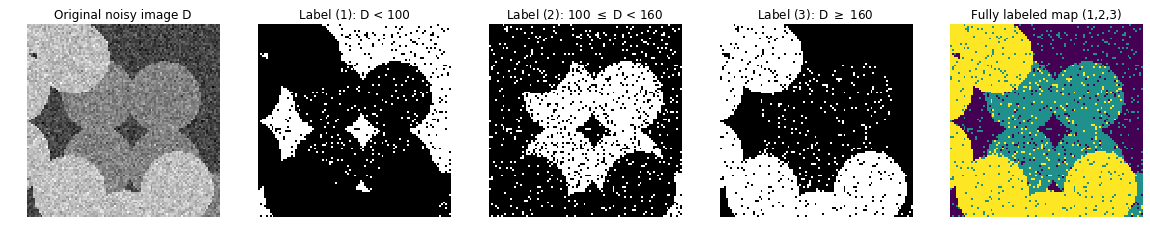

In [21]:
D = skimage.io.imread("noisy_circles.png").astype(np.int);

# Threshold D in D1, D2 and D3 with corresponding labels 1,2 and 3: (black = false, white = true)
D1 = (D < 100)*1
D2 = np.logical_and(D >= 100, D < 160)*2
D3 = (D >= 160)*3

# Make a 'complete' label map for D:
Dlabel = D1 + D2 + D3

# With this segmentation, already a clear distinction between background, and foreground is visible
f, ax = plt.subplots(1,5, figsize=(20,4))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0].imshow(D, cmap='gray')
ax[0].set(title=('Original noisy image D'))
ax[1].imshow(D1, cmap='gray');
ax[1].set(title=('Label (1): D < 100'))
ax[2].imshow(D2, cmap='gray');
ax[2].set(title=(r'Label (2): 100 $\leq$ D < 160'))
ax[3].imshow(D3, cmap='gray');
ax[3].set(title=(r'Label (3): D $\geq$ 160'));
ax[4].imshow(Dlabel);
ax[4].set(title=('Fully labeled map (1,2,3)'));

energy = Energy(D, Dlabel)
print('For the segmentation based on thresholding, the likelihood energy is', energy[0], 'and the prior energy is',energy[1])
print('The total energy is', energy[0] + energy[1])
print('This is a lot higher than the ground truth.')



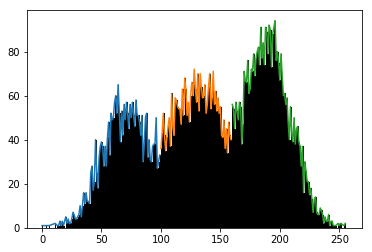

In [44]:
# Intermediate work: histogram of the thresholded image
plt.hist(D.ravel(), bins=256, range=[0,256], color='k');
for i in (1,2,3):
    PixVals, Counts = Histogrammify(D, Dlabel, i)
    plt.plot(PixVals, Counts)

### 5.2.3 Segmentation based on median filtering

For the segmentation based on thresholding, the likelihood energy is 2220.81 and the prior energy is 1534
The total energy is 3754.81
This is a lot lower than the simple thresholding: we can see that pixels are more "distant" from their mean (LE is higher) but neighbours are labeled very well.


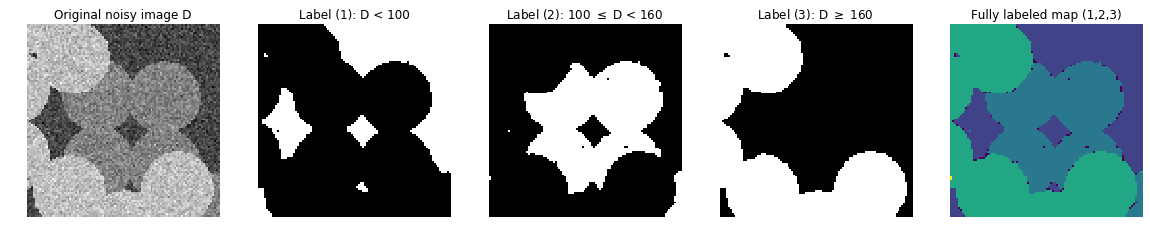

In [35]:
D1Median = skimage.filters.median(D1)
D2Median = skimage.filters.median(D2)
D3Median = skimage.filters.median(D3)

DMedianLabel = D1Median + D2Median + D3Median

# With this segmentation, already a clear distinction between background, and foreground is visible
f, ax = plt.subplots(1,5, figsize=(20,4))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0].imshow(D, cmap='gray')
ax[0].set(title=('Original noisy image D'))
ax[1].imshow(D1Median, cmap='gray');
ax[1].set(title=('Label (1): D < 100'))
ax[2].imshow(D2Median, cmap='gray');
ax[2].set(title=(r'Label (2): 100 $\leq$ D < 160'))
ax[3].imshow(D3Median, cmap='gray');
ax[3].set(title=(r'Label (3): D $\geq$ 160'));
ax[4].imshow(DMedianLabel);
ax[4].set(title=('Fully labeled map (1,2,3)'));

energy = Energy(D, DMedianLabel)
print('For the segmentation based on thresholding, the likelihood energy is', energy[0], 'and the prior energy is',energy[1])
print('The total energy is', energy[0] + energy[1])
print('This is a lot lower than the simple thresholding: we can see that pixels are more "distant" from their mean (LE is higher) but neighbours are labeled very well.')



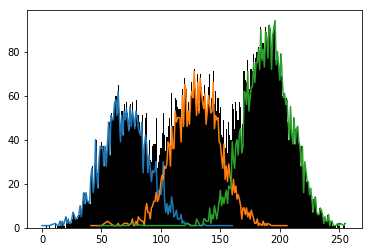

In [59]:
plt.hist(D.ravel(), bins=256, range=[1,256], color='k');
for i in (1,2,3):
    PixVals, Counts = Histogrammify(D, DMedianLabel, i)
    plt.plot(PixVals, Counts)

# Deformable Models



The mean intensities are 0.18715638328120557 inside and 0.12778920113236208 outside


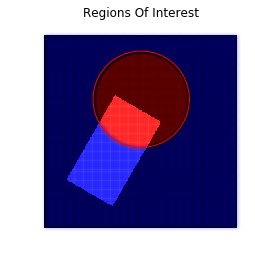

In [2]:
# Load data as binary image:
Square = skimage.color.rgb2gray(skimage.io.imread("TestImageSimple.png")).astype(np.int);
h,w = Square.shape

# Make the initial Snake a circle:
def InitSnake(center, radius, npoints):
    t = np.linspace(0,2*np.pi, npoints)
    Snake = np.asarray([center[0] + radius*np.cos(t), center[1] + radius*np.sin(t)])
    return Snake.T

Snake = InitSnake((150,100), 75, 40)

# Find Region Of Interest and its inverse mask (= Snake curve interior and exterior area) 
def FindROI(im, curve):
    # Allocate list names:
    ROI = []; notROI = []
    
    # Make set of all image indices:
    i,j = np.indices(im.shape)
    indices = np.asarray([i.flatten(),j.flatten()])
    
    # Divide set of indices into ROI (= inside polygon) or notROI (= outside polygon)
    truth = skimage.measure.points_in_poly(indices.T, curve)
    x = np.where(truth == True)
    ROI.append([indices[0, x], indices[1, x]])
    x = np.where(truth == False)
    notROI.append([indices[0, x], indices[1, x]])
    
    return np.asarray(ROI), np.asarray(notROI)

ROI, notROI = FindROI(Square, Snake)

plt.imshow(Square, cmap = 'gray');
plt.axis("off");
plt.plot(Snake[:,0], Snake[:,1], color = 'r', linewidth = 1)
plt.scatter(ROI[:,0], ROI[:,1], alpha = 0.007, color = 'r');
plt.scatter(notROI[:,0], notROI[:,1], alpha = 0.007, color = 'b');
plt.title('Regions Of Interest');

# Find mean intensities:
m_in  = np.mean(Square[ROI])
m_out = np.mean(Square[notROI])
print('The mean intensities are', m_in, 'inside and', m_out, 'outside')


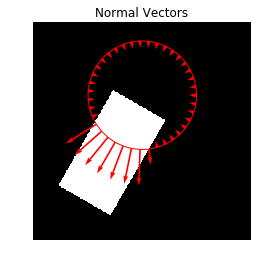

In [3]:
# Compute bilinear interpolaten of the Snake curve:
def BilinearInterpol(im, curve):
    # Associated intensity after interpolation:
    IntensityOut = np.zeros((curve.shape[0],1))
 
    x0 = np.floor(curve[:,0]).astype(np.int)
    x1 = np.ceil(curve[:,0]).astype(np.int)
    y0 = np.floor(curve[:,1]).astype(np.int)
    y1 = np.ceil(curve[:,1]).astype(np.int)
    dx = curve[:,0] - x0
    dy = curve[:,1] - y0
    IntensityOut[:,0] = im[y0,x0]*(1 - dx)*(1 - dy) + im[y0,x1]*dx*(1 - dy) + im[y1,x0]*(1 - dx)*dy + im[y1,x1]*dx*dy
    return IntensityOut

Intensities = BilinearInterpol(Square, Snake)

# Using these Regions Of Interest, Compute the magnitude (scalar value) of the Snake displacement:
# Fext =(m_in − m_out)*(2*I − m_in − m_out)*N
def ComputeDisplacement(im, curve):
    # Find mean intensities as before with ROI:
    ROI, notROI = FindROI(im, curve)
    m_in  = np.mean(im[ROI])
    m_out = np.mean(im[notROI])
    I = BilinearInterpol(im, curve)
    Fext = (m_in - m_out)*(2*I - m_in - m_out)
    return Fext

Fmagn = ComputeDisplacement(Square, Snake)

# Find normal vectors of the Snake curve:
def NormalVectors(im, curve):
    # Allocate space
    NormVecs = np.zeros((curve.shape[0],2))
    TangVecs = np.zeros((curve.shape[0],2))
    
    # Calculate tangent vectors with finite dfference
    TangVecs =  np.roll(curve,-1, axis = 0) - np.roll(curve,1, axis = 0)

    # Normalize lengths
    lengths = (TangVecs[:,0]**2 + TangVecs[:,1]**2)**0.5
    TangVecs[:,0] = TangVecs[:,0]/lengths
    TangVecs[:,1] = TangVecs[:,1]/lengths

    # Compute normal as a 90 degree rotation
    NormVecs[:,0] = TangVecs[:,1]
    NormVecs[:,1] = -TangVecs[:,0]
    
    # Multiply with correct lengths
    F = ComputeDisplacement(im, curve)
    NormVecs = np.multiply(NormVecs, F)
    return NormVecs

NormVecs = NormalVectors(Square,Snake)

plt.imshow(Square, cmap = 'gray');
plt.axis("off");
plt.plot(Snake[:,0], Snake[:,1], color = 'r', linewidth = 1)
plt.quiver(Snake[:,0], Snake[:,1], NormVecs[:,0], NormVecs[:,1], color = 'r', angles = 'xy')
plt.title('Normal Vectors');


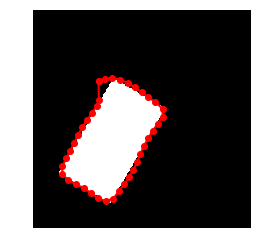

In [4]:
def SmoothKernel(curve, alpha, beta):
    l = curve.shape[0]
    B = np.zeros((l,l))
    
    # Construct the transformation matrices:
    # Kernel for minimum length
    Lml = -2*np.identity(l, dtype = None).astype(np.int); 
    Lml += np.roll(np.identity(l, dtype = None).astype(np.int),1,axis = 0)
    Lml += np.roll(np.identity(l, dtype = None).astype(np.int),-1,axis = 0)

    # Kernel for minimum curvature
    Lmc = -6*np.identity(l, dtype = None).astype(np.int); 
    Lmc += np.roll(-np.identity(l, dtype = None).astype(np.int),2,axis = 0)
    Lmc += np.roll(-np.identity(l, dtype = None).astype(np.int),-2,axis = 0)
    Lmc += np.roll(4*np.identity(l, dtype = None).astype(np.int),1,axis = 0)
    Lmc += np.roll(4*np.identity(l, dtype = None).astype(np.int),-1,axis = 0)
        
    I = np.identity(l, dtype = None).astype(np.int)
    B = np.linalg.inv(I - alpha*Lml - beta*Lmc)
    return B

B = SmoothKernel(Snake, 0.3, 0.2)

def updateCurve(im, curve, B):
    Vectors = NormalVectors(im, curve)
    # Apply algorithm from the course note: be aware of dimensions n x 2 <--> 2 x n so we hav to (re)transpose!
    curve = B@(curve + 50*Vectors)
    
    # Respace the points evenly
    Dist = (((curve[0:-1,0] - np.roll(curve[0:-1,0],-1))**2 + (curve[0:-1,1] - np.roll(curve[0:-1,1],-1))**2)**0.5)
    correctDist = np.linspace(0,np.sum(Dist),curve.shape[0])
    interpol = scipy.interpolate.interp1d(np.cumsum(Dist), curve[0:-1,0], fill_value="extrapolate")
    curve[:,0] = interpol(correctDist)
    interpol = scipy.interpolate.interp1d(np.cumsum(Dist), curve[0:-1,1], fill_value="extrapolate")
    curve[:,1] = interpol(correctDist)

    # Close the curve
    curve[-1,:] = curve[0,:]
    
    return curve

plt.imshow(Square, cmap = 'gray');
plt.axis("off");
Snake_tmp = updateCurve(Square, Snake, B)
for i in range(50):
    Snake_tmp = updateCurve(Square, Snake_tmp, B)
plt.plot(Snake_tmp[:,0], Snake_tmp[:,1], color = 'r', linewidth = 2)
plt.scatter(Snake_tmp[:,0], Snake_tmp[:,1], c = 'r')




# Function: snakes!


l = 100
B has shape (100, 100)
curve has shape (100, 2)
curve has shape (100, 2)
curve has shape (100, 2)
curve has shape (100, 2)
curve has shape (100, 2)


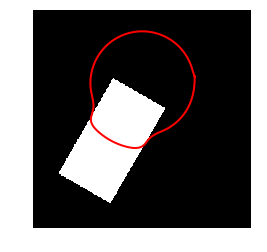

In [8]:
def DeformeableModel(im, curve, alpha, beta, stepsize, maxiter):
    l = curve.shape[0]
    print('l =',l)

    # 0. Make the smoothing kernel once
    B = np.zeros((l,l))

    # Kernel for minimum length
    Lml = -2*np.identity(l, dtype = None).astype(np.int); 
    Lml += np.roll(np.identity(l, dtype = None).astype(np.int),1,axis = 0)
    Lml += np.roll(np.identity(l, dtype = None).astype(np.int),-1,axis = 0)
    # Kernel for minimum curvature
    Lmc = -6*np.identity(l, dtype = None).astype(np.int); 
    Lmc += np.roll(-np.identity(l, dtype = None).astype(np.int),2,axis = 0)
    Lmc += np.roll(-np.identity(l, dtype = None).astype(np.int),-2,axis = 0)
    Lmc += np.roll(4*np.identity(l, dtype = None).astype(np.int),1,axis = 0)
    Lmc += np.roll(4*np.identity(l, dtype = None).astype(np.int),-1,axis = 0)
    # Apply formulae from the course note
    I = np.identity(l, dtype = None).astype(np.int)
    B = np.linalg.inv(I - alpha*Lml - beta*Lmc)
    print('B has shape',B.shape)

    
    for iteration in range(maxiter):
        # 1. Find Region Of Interest and its inverse mask (= Snake curve interior and exterior area) 
        ROI = []; notROI = []
        # Make set of all image indices:
        i,j = np.indices(im.shape)
        indices = np.asarray([i.flatten(),j.flatten()]) 
        # Divide set of indices into ROI (= inside polygon) or notROI (= outside polygon)
        truth = skimage.measure.points_in_poly(indices.T, curve)
        x = np.where(truth == True)
        ROI.append([indices[0, x], indices[1, x]])
        x = np.where(truth == False)
        notROI.append([indices[0, x], indices[1, x]])
        ROI = np.asarray(ROI)
        notROI = np.asarray(notROI)
    
        # 2. Compute bilinear interpolaten of the Snake curve:
        I = np.zeros((l,1))
        x0 = np.floor(curve[:,0]).astype(np.int)
        x1 = np.ceil(curve[:,0]).astype(np.int)
        y0 = np.floor(curve[:,1]).astype(np.int)
        y1 = np.ceil(curve[:,1]).astype(np.int)
        dx = curve[:,0] - x0
        dy = curve[:,1] - y0
        I[:,0] = im[y0,x0]*(1 - dx)*(1 - dy) + im[y0,x1]*dx*(1 - dy) + im[y1,x0]*(1 - dx)*dy + im[y1,x1]*dx*dy

        # 3. Using these Regions Of Interest, compute the magnitude (scalar value) of the Snake displacement:
        # Fext =(m_in − m_out)*(2*I − m_in − m_out)*N
        # Find mean intensities as before with ROI:
        m_in  = np.mean(im[ROI])
        m_out = np.mean(im[notROI])
        F = (m_in - m_out)*(2*I - m_in - m_out)

        # 4. Find normal vectors of the Snake curve:
        NormVecs = np.zeros((l,2))
        TangVecs = np.zeros((l,2))
        # Calculate tangent vectors with finite dfference
        TangVecs =  np.roll(curve,-1, axis = 0) - np.roll(curve,1, axis = 0)
        TangVecs[-1,:] = TangVecs[0,:]
        # Normalize lengths
        lengths = (TangVecs[:,0]**2 + TangVecs[:,1]**2)**0.5
        TangVecs[:,0] = TangVecs[:,0]/lengths
        TangVecs[:,1] = TangVecs[:,1]/lengths
        # Compute normal as a 90 degree rotation
        NormVecs[:,0] = TangVecs[:,1]
        NormVecs[:,1] = -TangVecs[:,0]
        # Multiply with correct lengths
        NormVecs = np.multiply(NormVecs, F)

        # 5. Update the curve
        if isinstance(stepsize, int):
            step = stepsize
        else:
            step = stepsize[iteration]
        curve = B@(curve + step*NormVecs)
        # Redistribute the points evenly
        Dist = (((curve[:,0] - np.roll(curve[:,0],-1))**2 + (curve[:,1] - np.roll(curve[:,1],-1))**2)**0.5)
        correctDist = np.linspace(0,np.sum(Dist),l)
        interpol = scipy.interpolate.interp1d(np.cumsum(Dist), curve[:,0], fill_value="extrapolate")
        curve[:,0] = interpol(correctDist)
        interpol = scipy.interpolate.interp1d(np.cumsum(Dist), curve[:,1], fill_value="extrapolate")
        curve[:,1] = interpol(correctDist)
        # Close the curve
        curve[-1,:] = curve[0,:]
        print('curve has shape',curve.shape)


    return curve

# Now run the deformable model function
Snake = InitSnake((150,100), 75, 100)

maxiter = 5
stepsize = np.linspace(50,10,maxiter)
NewSnake = DeformeableModel(Square, Snake, 0.2, 0.3, stepsize, maxiter)

plt.imshow(Square, cmap = 'gray');
plt.axis("off");
plt.plot(NewSnake[:,0], NewSnake[:,1], color = 'r', linewidth = 2);

